In [1]:
# Default setup과 tile 함수 정의부입니다.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "3_classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from PIL import Image
from itertools import product
import glob
import cv2 as cv

def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j+5, i+5, j+d-5, i+d-5)
        out = os.path.join(dir_out, f'{name}_{i//38}_{j//38}{ext}')
        img.crop(box).save(out)

아래 셀은 MNIST 데이터를 가져오고 X, y에 배정하는 내용입니다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

X, y = mnist["data"], mnist["target"] # X, y: pandas DataFrame
X, y = X.to_numpy(), y.to_numpy() # X, y: numpy array

In [3]:
X_beforeInsert, y_beforeInsert = X[0:0].copy(), y[0:0].copy()
X_forTest, y_forTest = X[0:0].copy(), y[0:0].copy()
# X_beforeInsert와 y_beforeInsert는 빈 ndarray

os 모듈을 import하고 파일들을 28 x 28 jpg 이미지 파일로 쪼개는 단계입니다. ⚠️ Directory 관련 안내: 상대 경로이므로 폴더를 재구성하지 마십시오.

### Training 데이터 추가하기
380 * 380 JPEG 이미지 파일을 /mnist_append/in 폴더에 추가하고 아레 셀을 실행하면 Training / Test Dataset에 3:1 비율로 추가됩니다.

In [4]:
path = sorted(glob.glob("mnist_append/in/*.jpg"))
print(path)
for i in range(len(path)):
    path[i] = os.path.basename(path[i])
    tile(path[i],"mnist_append/in" ,"mnist_append/out", 38)

['mnist_append/in\\dahoonlee1.jpg', 'mnist_append/in\\dahoonlee10.jpg', 'mnist_append/in\\dahoonlee11.jpg', 'mnist_append/in\\dahoonlee12.jpg', 'mnist_append/in\\dahoonlee13.jpg', 'mnist_append/in\\dahoonlee14.jpg', 'mnist_append/in\\dahoonlee15.jpg', 'mnist_append/in\\dahoonlee16.jpg', 'mnist_append/in\\dahoonlee17.jpg', 'mnist_append/in\\dahoonlee18.jpg', 'mnist_append/in\\dahoonlee19.jpg', 'mnist_append/in\\dahoonlee2.jpg', 'mnist_append/in\\dahoonlee20.jpg', 'mnist_append/in\\dahoonlee3.jpg', 'mnist_append/in\\dahoonlee4.jpg', 'mnist_append/in\\dahoonlee5.jpg', 'mnist_append/in\\dahoonlee6.jpg', 'mnist_append/in\\dahoonlee7.jpg', 'mnist_append/in\\dahoonlee8.jpg', 'mnist_append/in\\dahoonlee9.jpg', 'mnist_append/in\\heejuahn1.jpg', 'mnist_append/in\\heejuahn10.jpg', 'mnist_append/in\\heejuahn2.jpg', 'mnist_append/in\\heejuahn3.jpg', 'mnist_append/in\\heejuahn4.jpg', 'mnist_append/in\\heejuahn5.jpg', 'mnist_append/in\\heejuahn6.jpg', 'mnist_append/in\\heejuahn7.jpg', 'mnist_append/i

### For transfer image to array
아래 셀부터는 수집된 이미지를 배열로 전환하는 과정입니다.

Saving figure some_digit_plot
7번째의 X의 레이블은: 7


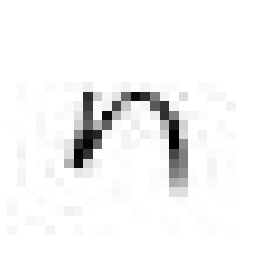

In [5]:
path = sorted(glob.glob("mnist_append/out/*.jpg"))

y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cv_img = []
for img in path:
    n = cv.imread(img, 0)
    n = 255 - n
    n = np.ravel(n, order='C')
    cv_img.append(n)

X_beforeInsert = np.concatenate((X_beforeInsert, cv_img), axis=0)
y_beforeInsert = np.append(y_beforeInsert, y_labels * (len(cv_img)//10))

a = 7 # want to know
some_digit = X_beforeInsert[a]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("some_digit_plot")
print(a, "번째의 X의 레이블은: ", y_beforeInsert[a], sep="")

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = X[:67500], X[67500:], y[:67500], y[67500:]
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_beforeInsert, y_beforeInsert, test_size=0.25, shuffle=True, stratify=y_beforeInsert, random_state=42)
X_train = np.concatenate((X_train, X_i_train), axis=0)
X_test = np.concatenate((X_test, X_i_test), axis=0)
y_train = np.append(y_train, y_i_train)
y_test = np.append(y_test, y_i_test)

0
Saving figure some_digit_plot
신규 데이터 중 train 데이터 비율: 0.75
신규 데이터 중 test 데이터 비율: 0.25
72075 4025 4025


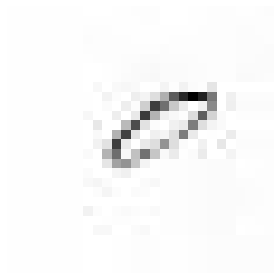

In [7]:
some_digit = X_test[2774]
print(y_test[2774])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
save_fig("some_digit_plot")
print("신규 데이터 중 train 데이터 비율:", (len(X_train)-67500)/(len(X_train)-67500 + len(X_test)-2500))
print("신규 데이터 중 test 데이터 비율:", (len(X_test)-2500)/((len(X_train)-67500 + len(X_test)-2500)))
print(len(X_train), len(X_test), len(y_test))

In [8]:
# Test만을 위한 데이터를 X_test와 y_test에 붙이는 셀
pathTestOut = sorted(glob.glob("mnist_append/fortest_out/*.jpg"))

y_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cv_img = []
for img in pathTestOut:
    n = cv.imread(img, 0)
    n = 255 - n
    n = np.ravel(n, order='C')
    cv_img.append(n)

X_forTest = np.concatenate((X_forTest, cv_img), axis=0)
y_forTest = np.append(y_forTest, y_labels * (len(cv_img)//10))
X_test = np.concatenate((X_test, X_forTest), axis=0)
y_test = np.append(y_test, y_forTest)

In [9]:
# 이 아래 셀부터 모델을 만드시면 됩니다.
# mnist_append/in에 380*380 이미지를 넣고 Markdown H3 For competition 밑에 있는 셀을 실행하면 mnist_append/out에 28*28로
# 슬라이스한 이미지가 저장되고, 바로 아래 셀에서는 import한 이미지를 X에 붙이고, 순서대로 레이블링하여 y에 붙이는 작업을 수행합니다.
# 최종 제출 전에 이 주석을 삭제하십시오.
# 파일 이름(최초: Untitled.ipynb)은 적절하게 바꾸시면 됩니다. 귀찮아서 이름을 안 지었습니다.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [11]:
from sklearn.preprocessing import RobustScaler
rscaler=RobustScaler()
X_train_rscaled=rscaler.fit_transform(X_train)
X_test_rscaled=rscaler.transform(X_test)

In [12]:
from sklearn.preprocessing import MinMaxScaler
mscaler=MinMaxScaler()
X_train_mscaled=mscaler.fit_transform(X_train)
X_test_mscaled=mscaler.transform(X_test)

In [13]:
from sklearn.preprocessing import Normalizer
nor=Normalizer()
X_train_normalized=nor.fit_transform(X_train)
X_test_normalized=nor.transform(X_test)

In [14]:
scores={}
processing_times={}
predict_times={}

In [15]:
def fit_and_calScoreTime(clf,tr_data,ts_data,tr_label,ts_label):
    fit_st=time.time()
    clf.fit(tr_data,tr_label)
    fit_time=time.time()-fit_st
    
    pred_st=time.time()
    predictions=clf.predict(ts_data)
    pred_time=time.time()-pred_st
    
    score=accuracy_score(ts_label,predictions)
    return score,fit_time,pred_time

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

names=["SGD","LogisticRegression",
       "KNearest Neighbors",
       "Multi-Layter Perceptron",
       "Linear SVM",
       "Gaussian Naive Bayes",
       "Nearest Centroid","Multinomial Naive Bayes"]

classifiers=[
    SGDClassifier(random_state=42),
    LogisticRegression(),
    KNeighborsClassifier(),
    MLPClassifier(random_state=42),
    SVC(random_state=42),
    GaussianNB(),
    NearestCentroid(),
    MultinomialNB()
]

    
for name,clf in zip(names,classifiers):
    scaling_names=['No scaling','StandardScaler',"RobustScaler","MinMaxScaler","Normalizer"]
    t_scores=[]
    t_fit_times=[]
    t_pred_times=[]
    
    #no scaling
    score,fit_time,pred_time=fit_and_calScoreTime(clf,X_train,X_test,y_train,y_test)
    t_scores.append(score)
    t_fit_times.append(fit_time)
    t_pred_times.append(pred_time)
    
    try:
        #standardScaler
        sscore,sfit_time,spred_time=fit_and_calScoreTime(clf,X_train_scaled,X_test_scaled,y_train,y_test)
        t_scores.append(sscore)
        t_fit_times.append(sfit_time)
        t_pred_times.append(spred_time)
    
        #robustScaler
        rscore,rfit_time,rpred_time=fit_and_calScoreTime(clf,X_train_rscaled,X_test_rscaled,y_train,y_test)
        t_scores.append(rscore)
        t_fit_times.append(rfit_time)
        t_pred_times.append(rpred_time)
    
        #minmaxScaler
        mscore,mfit_time,mpred_time=fit_and_calScoreTime(clf,X_train_mscaled,X_test_mscaled,y_train,y_test)
        t_scores.append(mscore)
        t_fit_times.append(mfit_time)
        t_pred_times.append(mpred_time)
    
        #normalizer
        nscore,nfit_time,npred_time=fit_and_calScoreTime(clf,X_train_normalized,X_test_normalized,y_train,y_test)
        t_scores.append(nscore)
        t_fit_times.append(nfit_time)
        t_pred_times.append(npred_time)
    
        for i in range(len(scaling_names)):
            input_name=name+'('+scaling_names[i]+')'
            print(f"[{name} ({scaling_names[i]})] score: {t_scores[i]}, training time : {t_fit_times[i]}, prediction time : {t_pred_times[i]}")
            scores[input_name]=t_scores[i]
            processing_times[input_name]=t_fit_times[i]
            predict_times[input_name]=t_pred_times[i]
            
    except ValueError:
        continue

    

D:\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[SGD (No scaling)] score: 0.5822485207100592, training time : 288.6637623310089, prediction time : 0.019948720932006836
[SGD (StandardScaler)] score: 0.5950295857988166, training time : 760.227620601654, prediction time : 0.0827789306640625
[SGD (RobustScaler)] score: 0.5723076923076923, training time : 340.7666699886322, prediction time : 0.1466047763824463
[SGD (MinMaxScaler)] score: 0.6340828402366864, training time : 55.75406789779663, prediction time : 0.1545867919921875
[SGD (Normalizer)] score: 0.6324260355029586, training time : 21.659356355667114, prediction time : 0.15934205055236816


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

[LogisticRegression (No scaling)] score: 0.6411834319526627, training time : 126.27264404296875, prediction time : 0.11692237854003906
[LogisticRegression (StandardScaler)] score: 0.6369230769230769, training time : 102.08091473579407, prediction time : 0.24743437767028809
[LogisticRegression (RobustScaler)] score: 0.5846153846153846, training time : 121.47153759002686, prediction time : 0.19229936599731445
[LogisticRegression (MinMaxScaler)] score: 0.6433136094674556, training time : 115.740975856781, prediction time : 0.17913293838500977
[LogisticRegression (Normalizer)] score: 0.6435502958579882, training time : 113.97301864624023, prediction time : 0.15102291107177734
[KNearest Neighbors (No scaling)] score: 0.7126627218934911, training time : 2.2583506107330322, prediction time : 46.30648970603943
[KNearest Neighbors (StandardScaler)] score: 0.6930177514792899, training time : 3.8219892978668213, prediction time : 32.56749176979065
[KNearest Neighbors (RobustScaler)] score: 0.5763